<a href="https://colab.research.google.com/github/shazzad-hasan/ethereum-fraud-detection/blob/main/models/LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, f1_score, recall_score, accuracy_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, BaseEstimator
from typing import Union, Optional
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/combined_kaggle_etherscan_ts_data.csv').drop(columns=['Unnamed: 0'])

feature_list = list(set(df.columns) - set(['Address', 'FLAG']))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, stratify=df['FLAG'])

In [ ]:
print("Number of training samples: ", df_train.shape[0])
print("Number of Test samples: ", df_test.shape[0])

Number of training samples:  11136
Number of Test samples:  2784


In [ ]:
%run "/content/drive/MyDrive/ethereum-fraud-detection/models/helper_data_preprocessing.py"

In [ ]:
dp = DataPrep(
    features=feature_list,
    fill_strategy='median',
    upper_clip_quantile=0.95,
    lower_clip_quantile=0.05
)

In [ ]:
df_train_prep = dp.fit_transform(df_train)
df_test_prep = dp.transform(df_test)

In [ ]:
scaler = StandardScaler()
df_train_prep = scaler.fit_transform(df_train_prep[feature_list])
df_test_prep = scaler.transform(df_test_prep[feature_list])

In [ ]:
lgbm = lgb.LGBMClassifier(random_state=42)
params = {
    "learning_rate": [0.01, 0.1],
    "num_leaves": [100, 200],
    "max_depth": [5, 10, 20],
    "max_bin": [100, 200, 500],
    "min_gain_to_split": [0, 5, 10],
    "bagging_fraction": [0.5, 0.7, 0.9],
    "bagging_freq": [1],
    "feature_fraction": [0.5, 0.7, 0.9]
}

clf = GridSearchCV(estimator=lgbm,
                   param_grid=params,
                   cv=5,
                   n_jobs=-1,
                   scoring="f1")
clf.fit(df_train_prep, df_train['FLAG'])

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Info] Number of positive: 5026, number of negative

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'bagging_fraction': [0.5, 0.7, 0.9],
                         'bagging_freq': [1],
                         'feature_fraction': [0.5, 0.7, 0.9],
                         'learning_rate': [0.01, 0.1],
                         'max_bin': [100, 200, 500], 'max_depth': [5, 10, 20],
                         'min_gain_to_split': [0, 5, 10],
                         'num_leaves': [100, 200]},
             scoring='f1')

In [ ]:
print("Tuned Hyperparameters :", clf.best_params_)

Tuned Hyperparameters : {'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.9, 'learning_rate': 0.1, 'max_bin': 100, 'max_depth': 10, 'min_gain_to_split': 0, 'num_leaves': 200}


In [ ]:
print('train roc_auc_score: ', roc_auc_score(df_train['FLAG'], clf.predict_proba(df_train_prep)[:, 1]))
print('test roc_auc_score: ', roc_auc_score(df_test['FLAG'], clf.predict_proba(df_test_prep)[:, 1]))

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
train roc_auc_score:  0.9999854113763911
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
test roc_auc_score:  

In [ ]:
y_pred = clf.predict(df_test_prep)

print("F1 Score: {}\nRecall: {}\nAccuracy: {}\nPrecision: {}".format(
    f1_score(df_test['FLAG'], y_pred),
    recall_score(df_test['FLAG'], y_pred),
    accuracy_score(df_test['FLAG'], y_pred),
    precision_score(df_test['FLAG'], y_pred))
)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
F1 Score: 0.9296781883194278
Recall: 0.9307875894988067
Accuracy: 0.9364224137931034
Precision: 0.9285714285714286


              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1527
           1       0.93      0.93      0.93      1257

    accuracy                           0.94      2784
   macro avg       0.94      0.94      0.94      2784
weighted avg       0.94      0.94      0.94      2784



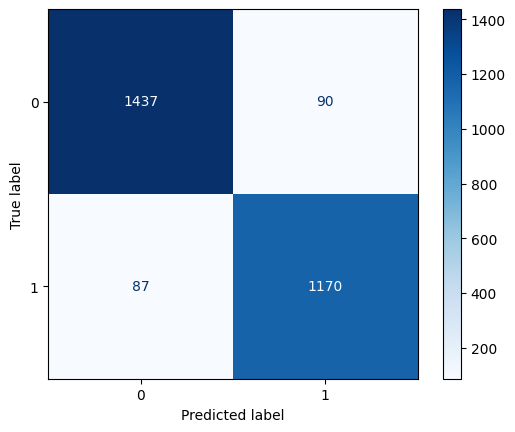

In [ ]:
print(classification_report(df_test['FLAG'], y_pred))
cm = confusion_matrix(df_test['FLAG'], y_pred)

cmap = sns.color_palette("Blues", as_cmap=True)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=cmap)

plt.show()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


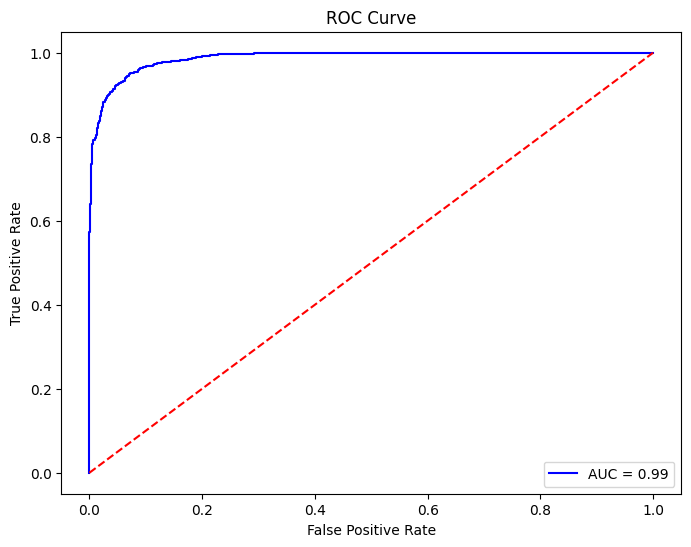

In [ ]:
y_pred = clf.predict_proba(df_test_prep)[:, 1]
fpr, tpr, threshold = roc_curve(df_test['FLAG'], y_pred)
roc_auc = auc(fpr, tpr)

roc_data = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_data.to_csv('/content/drive/MyDrive/ethereum-fraud-detection/results/roc_data_lightgbm.csv', index=False)

plt.figure(figsize=(8,6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

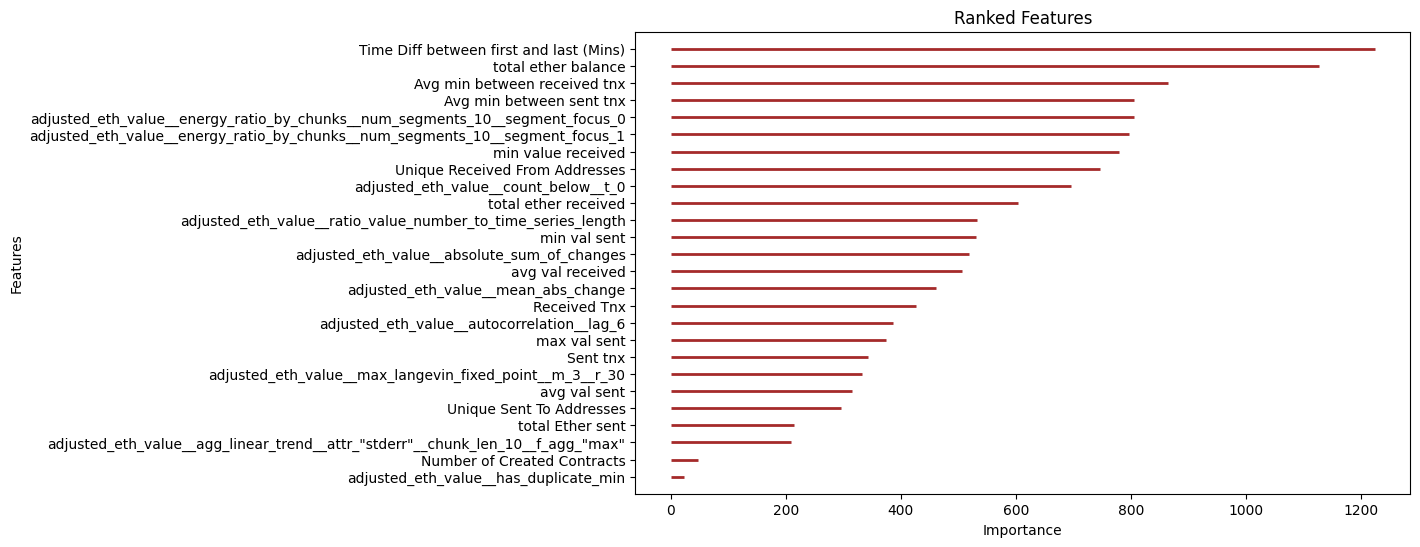

In [ ]:
feat_importances = clf.best_estimator_.feature_importances_
indices = np.argsort(feat_importances)

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked Features")
y_positions = range(len(feat_importances))
plt.hlines(y=y_positions, xmin=0, xmax=feat_importances[indices], color='brown', linewidth=2)
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(y_positions, [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

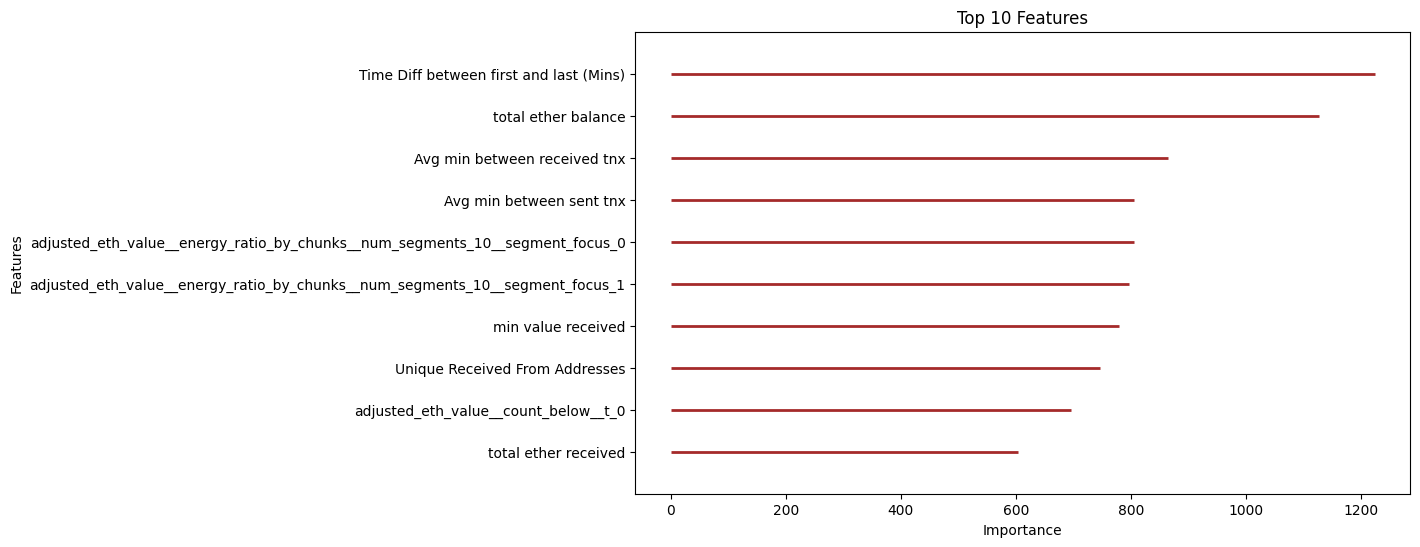

In [ ]:
indices = np.argsort(feat_importances)
top_10_indices = indices[-10:]

fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Top 10 Features")
y_positions = range(len(top_10_indices))
plt.hlines(y=y_positions, xmin=0, xmax=feat_importances[top_10_indices], color='brown', linewidth=2)
features = ['{}'.format(feature_list[i]) for i in range(len(feature_list))]
plt.yticks(y_positions, [features[idx] for idx in top_10_indices])
plt.ylim([-1, len(top_10_indices)])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
# Save the model
pickle_out = open('/content/drive/MyDrive/ethereum-fraud-detection/saved-models/LightGBM.pickle', 'wb')
pickle.dump(clf, pickle_out)
pickle_out.close()